In [15]:
import pandas as pd
import numpy as np
import sys
sys.path.insert(0, '../')
sys.path.insert(0, '../GGH')

from tqdm import tqdm
import cProfile, pstats, io

from GGH.data_ops import DataOperator
from GGH.selection_algorithms import AlgoModulators
from GGH.models import initialize_model, Autoencoder
from GGH.train_val_loop import TrainValidationManager
from GGH.inspector import Inspector, plot_histogram, visualize_train_val_error, selection_histograms, create_heatmap, cluster_and_visualize, \
                          get_gradarrays_n_labels, prep_tsne_min_max_ranges, sep_grads_by_labels, reset_pt_files, clean_final_analysis, \
                          clean_final_analysis
from GGH.imputation_methods import Imputer
import warnings
warnings.filterwarnings('ignore')

def full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, results_path, dropout = 0.05, lr = 0.001, nu = 0.1, 
                    normalize_grads_contx = False, use_context = True, final_analysis = False, use_auc_loss = False, use_confidence_weighting = False):
       
    AM = AlgoModulators(DO, lr = lr, nu = nu, normalize_grads_contx = normalize_grads_contx, use_context = use_context, freqperc_cutoff = 0.20, 
                        use_confidence_weighting = use_confidence_weighting)
    dataloader = DO.prep_dataloader(use_info, batch_size)

    model = initialize_model(DO, dataloader, hidden_size, rand_state, dropout = dropout) 

    TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, rand_state, results_path, final_analysis = final_analysis)
    TVM.train_model(DO, AM, model, final_analysis = final_analysis)

    INSPECT.save_train_val_logs(DO, AM, TVM, model, final_analysis = final_analysis)
    
    return DO, TVM, model

def multi_experiments(total_runs, use_info, num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                      INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters, final_analysis = True):
    
    clean_final_analysis(results_path, use_info)
    progress_bar = tqdm(total=total_runs)
    for r_state in range(42, 2000): #
        set_to_deterministic(r_state)
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, r_state, results_path,
                            hyperparameters["dropout"]["value"], hyperparameters["lr"]["value"], hyperparameters["nu"]["value"],
                            hyperparameters["normalize_grads_contx"]["value"], hyperparameters["use_context"]["value"], final_analysis,
                            use_confidence_weighting = hyperparameters["use_confidence_weighting"]["value"])
            
            progress_bar.update(1)
        if progress_bar.n == total_runs:
            break       
    progress_bar.close()
    
def set_to_deterministic(rand_state):
    
    import random
    import numpy as np
    import torch
    
    random.seed(rand_state)
    np.random.seed(rand_state)
    torch.manual_seed(rand_state)

    torch.set_num_threads(1)
    #torch.set_num_interop_threads(1)
    torch.use_deterministic_algorithms(True)

In [3]:
df = pd.read_csv('../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv')

df.head()

,aryl_halides,solvent,photocalysts,solvent_photocatalyst,piperidines,catalysts,ni_catalysts,ni_solvent,products,uplcms,aryl_halides_moles,photocalysts_moles,piperidines_moles,catalysts_moles,ni_catalysts_moles
0,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,CS(C)=O,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1.F[P-](F)...,CS(C)=O,C1CCNCC1,C1CN2CCN1CC2,COCCOC.Cl[Ni]Cl,CS(C)=O,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)N4CCCCC4,0.000000,100,0.5,150,180,5
1,c1cc2c(cc1Cl)[C@@](OC(=O)N2)(C#CC3CC3)C(F)(F)F,CS(C)=O,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1.F[P-](F)...,CS(C)=O,C1CCNCC1,C1CN2CCN1CC2,COCCOC.Cl[Ni]Cl,CS(C)=O,c1cc2c(cc1N3CCCCC3)C(OC(=O)N2)(C#CC4CC4)C(F)(F)F,1.997999,100,0.5,150,180,5
2,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,CS(C)=O,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1.F[P-](F)...,CS(C)=O,C1CCNCC1,C1CN2CCN1CC2,COCCOC.Cl[Ni]Cl,CS(C)=O,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)N4CCCCC4,0.000000,100,0.5,150,180,5
3,c1cc2c(cc1Cl)[C@@](OC(=O)N2)(C#CC3CC3)C(F)(F)F,CS(C)=O,CC(C)(C)c1ccnc(-c2cc(C(C)(C)C)ccn2)c1.F[P-](F)...,CS(C)=O,C1CCNCC1,C1CN2CCN1CC2,COCCOC.Cl[Ni]Cl,CS(C)=O,c1cc2c(cc1N3CCCCC3)C(OC(=O)N2)(C#CC4CC4)C(F)(F)F,2.353645,100,0.5,150,180,5
4,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)Br,CS(C)=O,Fc1cc(F)c(-c2ccccn2)c([Ir](c2cc(F)cc(F)c2-c2cc...,CS(C)=O,C1CCNCC1,C1CN2CCN1CC2,COCCOC.Cl[Ni]Cl,CS(C)=O,COC(=O)CC1CCc2cc(cc3c2n1c(=O)c(=O)[nH]3)N4CCCCC4,0.000000,100,0.5,150,180,5


In [7]:
print(len(df["aryl_halides_moles"].value_counts()))
print(len(df["photocalysts_moles"].value_counts()))
print(len(df["piperidines_moles"].value_counts()))
print(len(df["catalysts_moles"].value_counts()))
print(len(df["ni_catalysts_moles"].value_counts()))
print(len(df["photocalysts"].value_counts()))
print(len(df["catalysts"].value_counts()))
print(len(df["ni_catalysts"].value_counts()))

1
4
2
1
1
11
1
1


In [8]:
#User requiered data and parameters
data_path = '../data/photoredox_yield/photo_redox_merck2021_1649reactions.csv'
results_path = "../saved_results/Photoredox Yield"
inpt_vars = ['aryl_halides', 'photocalysts', 'piperidines_moles']
target_vars = ['uplcms']

miss_vars = ['photocalysts_moles']
hypothesis = [[0.02, 0.05, 0.50, 5.0]] 

#Percentage of simulated data with full information
partial_perc = 0.1 #0.1, 0.2, 0.3
rand_state = 42

#Model Train Parameters
hidden_size = 32
batch_size = 100*len(hypothesis[0])
output_size = len(target_vars)

#Call data, algorithm and model classes
INSPECT = Inspector(results_path, hidden_size)

reset_pt_files(results_path)

Total .pt files deleted: 168


168

100%|██████████| 60/60 [14:18<00:00, 14.31s/it]


0.7027825691950427
0.6728435437290965


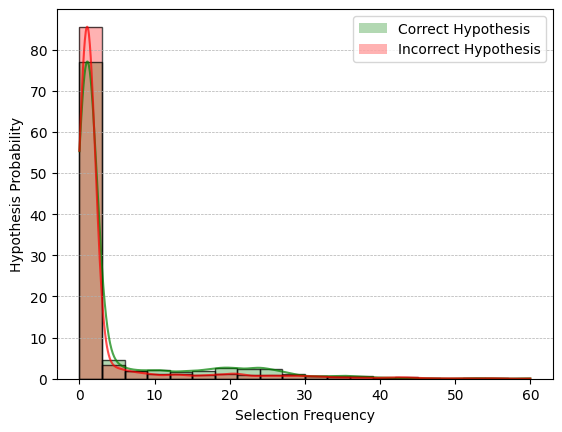

In [22]:
partial_perc = 0.15
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 60
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")

DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.1, normalize_grads_contx = True, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

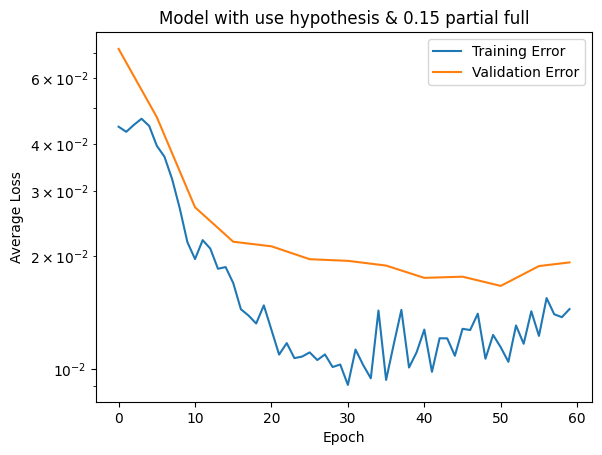

In [23]:
visualize_train_val_error(DO, TVM)

100%|██████████| 60/60 [13:00<00:00, 13.01s/it]


0.7554190424038275
0.7304004234996505


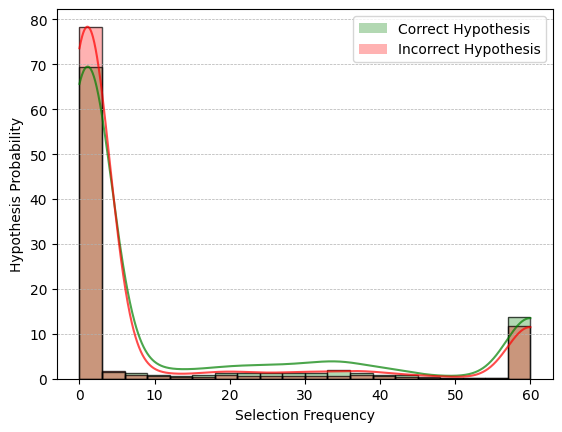

In [24]:
partial_perc = 0.15
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 60
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")

DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

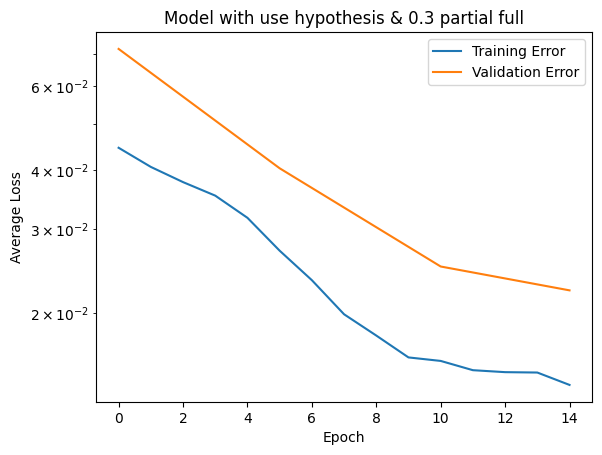

In [19]:
visualize_train_val_error(DO, TVM)

100%|██████████| 60/60 [11:28<00:00, 11.48s/it]


0.7359498989566995
0.6896636502437099


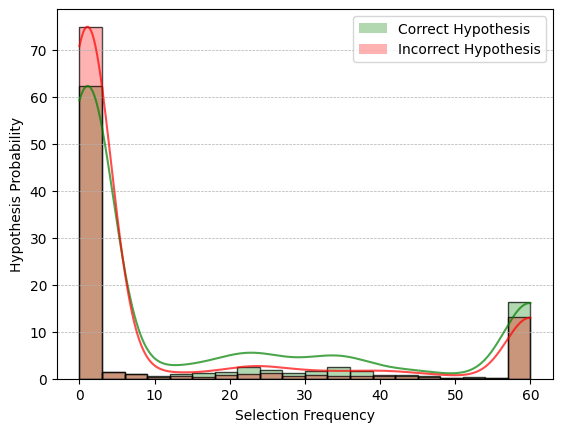

In [20]:
#Algo Modulator, freqperc_cutoff = 0.20
partial_perc = 0.20
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 60
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.05, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 60/60 [06:49<00:00,  6.82s/it]


0.7231865603540912
0.7277935048165214


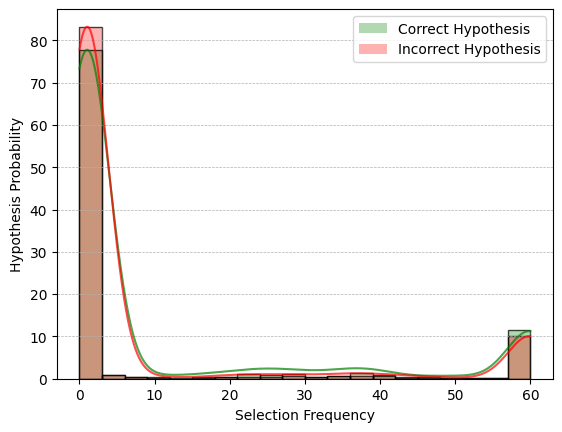

In [21]:
#Algo Modulator, freqperc_cutoff = 0.20
partial_perc = 0.10
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 60
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.05, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

  0%|          | 0/40 [00:00<?, ?it/s]/home/pneves6/git_repos/PhD/gradient_guided_hypotheses/notebooks/../GGH/custom_optimizer.py:57: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.cpp:1519.)
  exp_avg.mul_(beta1).add_(1 - beta1, grad)
100%|██████████| 40/40 [07:39<00:00, 11.49s/it]


0.7388102226287208
0.7018416928030489


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


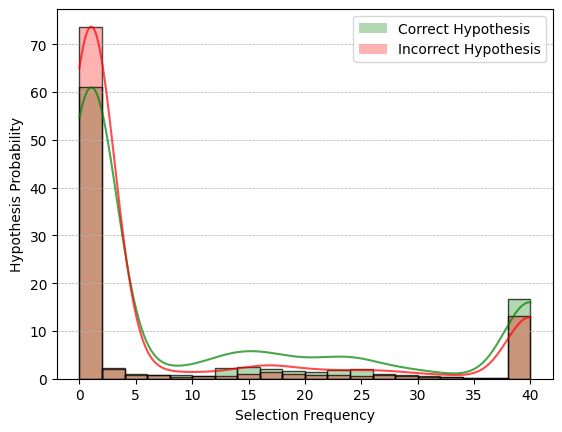

In [12]:
partial_perc = 0.20
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.05, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 40/40 [07:39<00:00, 11.49s/it]


0.6186015130318082
0.7173166553375936


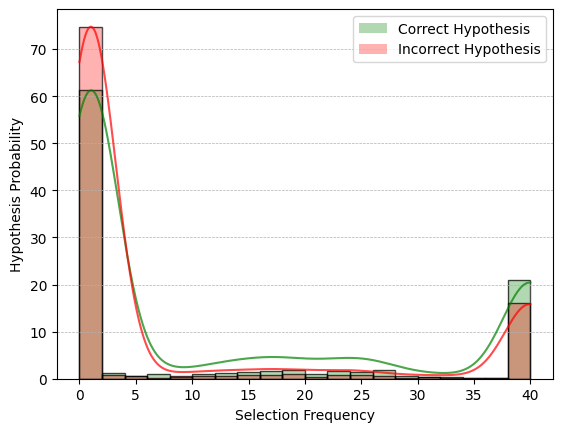

In [14]:
partial_perc = 0.20
rand_state = 10

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.05, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 40/40 [07:38<00:00, 11.47s/it]


0.7406753369699995
0.6962128576327946


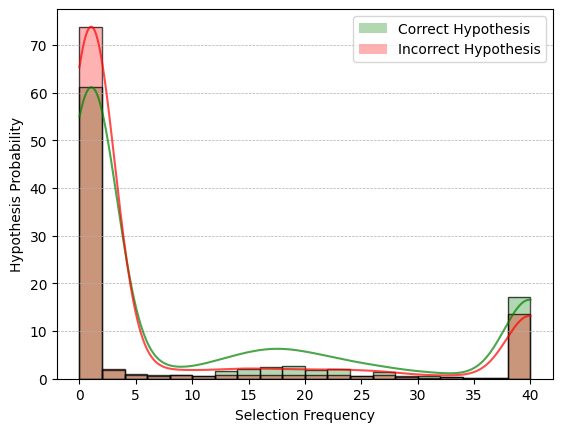

In [15]:
partial_perc = 0.20
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.2, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 40/40 [07:39<00:00, 11.48s/it]


0.7260550673756769
0.6972494527457449


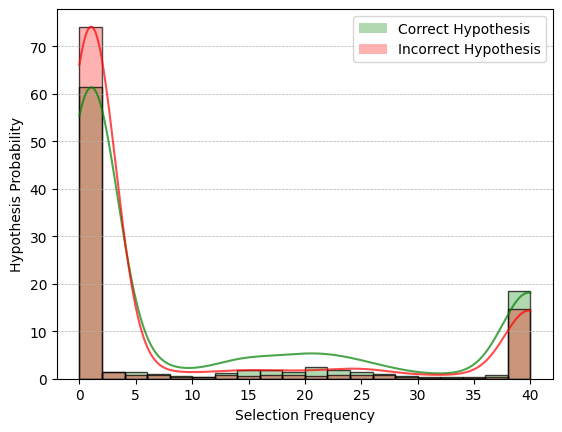

In [16]:
partial_perc = 0.20
rand_state = 0

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.2, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 40/40 [07:38<00:00, 11.46s/it]


0.6325658027938097
0.7194272956586936


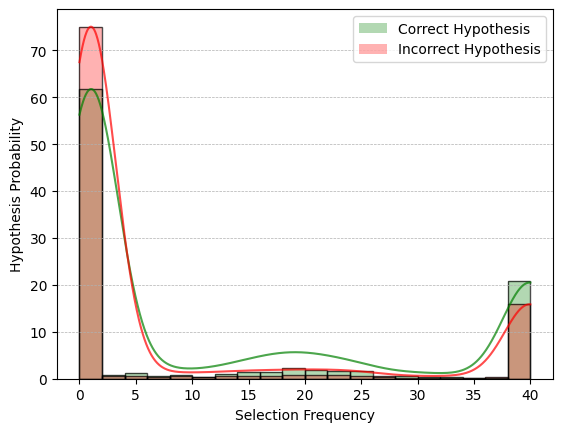

In [17]:
partial_perc = 0.20
rand_state = 10

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.2, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

100%|██████████| 40/40 [07:49<00:00, 11.73s/it]


0.7405814168278746
0.6975895727659633


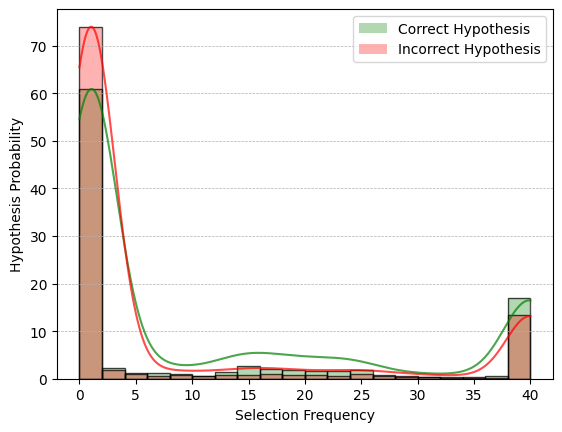

In [18]:
partial_perc = 0.20
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.15, normalize_grads_contx = False, use_context = False, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [ ]:
partial_perc = 0.20
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 40
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.15, normalize_grads_contx = False, use_context = False, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

  0%|          | 0/60 [00:00<?, ?it/s]/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/torch/autograd/__init__.py:394: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 11080). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  result = Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass
/home/pneves6/git_repos/PhD/Gradient_Guided_Hypothesis/notebooks/../GGH/custom_optimizer.py:57: UserWarning: This overload of add_ is deprecated:
	add_(Number alpha, Tensor other)
Consider using one of the following signatures instead:
	add_(Tensor other, *, Number alpha) (Triggered internally at ../torch/csrc/utils/python_arg_parser.c

0.7388671926999172
0.7026526361095833


findfont: Font family ['Cambria'] not found. Falling back to DejaVu Sans.


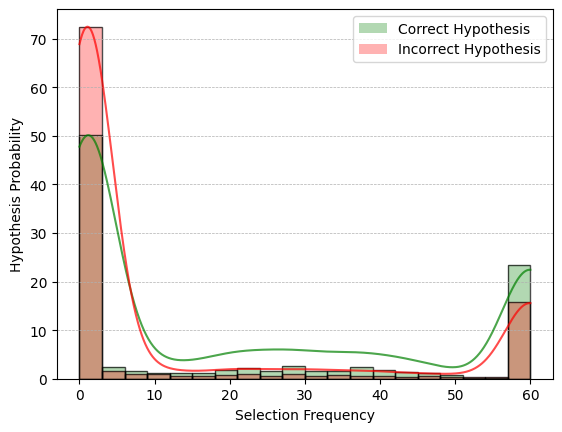

In [4]:
partial_perc = 0.3
rand_state = 42

#best was, drop 0.05, context true, normalized
use_info = "use hypothesis"
num_epochs = 60
DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, rand_state, device = "cpu")
DO, TVM, model = full_experiment(use_info, DO, INSPECT, batch_size, hidden_size, output_size, num_epochs, rand_state, 
                                 results_path, dropout = 0.05, lr = 0.001, nu = 0.1, normalize_grads_contx = False, use_context = True, final_analysis = False)

print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "validation"))
print(INSPECT.calculate_val_r2score(DO, TVM, model, data = "test"))

selection_histograms(DO, TVM, num_epochs, rand_state, partial_perc)

In [29]:
#%%capture

#Number of loops to ensure statistical significance
num_loops = 3
num_epochs = 120
partial_perc = 0.1

hyperparameters = {"lr": {"value": 0.001}, "dropout": {"value": 0.05}, "nu": {"value": 0.1},
                   "normalize_grads_contx": {"value":False}, "use_context": {"value":True},
                   "use_confidence_weighting": {"value":True}}


multi_experiments(num_loops, "use hypothesis", num_epochs, data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "partial info",   int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, 
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "use known only", int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)
multi_experiments(num_loops, "full info",      int(num_epochs*2.5), data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc,
                  INSPECT, batch_size, hidden_size, output_size, results_path, hyperparameters)

Deleted 1 files in: ../saved_results/Photoredox Yield/use hypothesis/final_analysis




100%|██████████| 12/12 [02:19<00:00, 11.65s/it]


100%|██████████| 12/12 [02:20<00:00, 11.68s/it][A


100%|██████████| 12/12 [02:19<00:00, 11.64s/it][A


100%|██████████| 3/3 [07:00<00:00, 140.06s/it]


Deleted 45 files in: ../saved_results/Photoredox Yield/partial info/final_analysis


100%|██████████| 3/3 [00:00<00:00,  4.71it/s]


Deleted 45 files in: ../saved_results/Photoredox Yield/use known only/final_analysis


100%|██████████| 3/3 [00:01<00:00,  2.37it/s]


Deleted 45 files in: ../saved_results/Photoredox Yield/full info/final_analysis


100%|██████████| 3/3 [00:01<00:00,  2.09it/s]


In [30]:
#10%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "")
df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
3,partial info,0.075465,0.059348,0.164671
4,use hypothesis,0.552403,0.028875,0.109693
6,use known only,0.600628,0.025471,0.103589


In [31]:
df_notavg[df_notavg["Method"]=="use hypothesis"]["avg_r2_score"].values

array([list([0.6070611095034442, 0.5439400036791343, 0.5062076539662742])],
      dtype=object)

In [10]:
%%capture
for imput_method in ["Iterative MICE Imputer", "KNN Imputer", "Miss Forest", "Deep Regressor", "Soft Impute", 
                     "Matrix Factorization",  "Hyperimpute", "TabPFN"]: # "Midas"
    counter = 0
    use_info = "use imputation"
    num_epochs = 300
    for r_state in range(100):
        DO = DataOperator(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, r_state, device = "cpu")
        if not DO.lack_partial_coverage:
            counter += 1
            AM = AlgoModulators(DO)
            IMP = Imputer(DO)
            dataloader = IMP.impute_w_sel(DO, imput_method, batch_size)

            model = initialize_model(DO, dataloader, hidden_size, r_state, dropout = 0.05) 
            TVM = TrainValidationManager(use_info, num_epochs, dataloader, batch_size, r_state, results_path,
                                        imput_method = imput_method, final_analysis = True)
            TVM.train_model(DO, AM, model)
            INSPECT.save_train_val_logs(DO, AM, TVM, model, imput_method, final_analysis = True)
        if counter == 15:
            break

In [6]:
#30%
#best performing nuclear norm regularization
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Deep Regressor,0.017084,0.003379
1,Hyperimpute,0.017843,0.004644
2,Iterative MICE Imputer,0.017325,0.003841
3,KNN Imputer,0.017123,0.003261
4,Matrix Factorization,0.016901,0.003684
5,Miss Forest,0.019669,0.006347
6,Soft Impute,0.013716,0.002942
7,TabPFN,0.016677,0.003868


In [7]:
#30%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "Soft Impute")
df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda

,Method,avg_r2_score,avg_mse,avg_mae
1,full info,0.850844,0.007482,0.043677
3,partial info,0.691260,0.015394,0.072316
4,use hypothesis,0.715718,0.014270,0.065107
5,use imputation,0.732290,0.013522,0.065149
6,use known only,0.687870,0.015607,0.069207


In [7]:
#20%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "Soft Impute")
df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda

,Method,avg_r2_score,avg_mse,avg_mae
1,full info,0.850844,0.007482,0.043677
3,partial info,0.631352,0.018373,0.081971
5,use imputation,0.729325,0.013702,0.065937
6,use known only,0.687870,0.015607,0.069207


In [11]:
#10%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "Soft Impute")
df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/fromnumeric.py:3440: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:262: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:222: RuntimeWarning: invalid value encountered in true_divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/home/pneves6/.conda/envs/bee_py38/lib/python3.8/site-packages/numpy/core/_methods.py:254: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/pneves6/.conda

,Method,avg_r2_score,avg_mse,avg_mae
1,full info,0.850844,0.007482,0.043677
3,partial info,0.440526,0.028031,0.106484
5,use imputation,0.696882,0.015331,0.070560
6,use known only,0.687870,0.015607,0.069207


In [ ]:
#30%
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "Soft Impute")
#df.dropna(inplace = True)
#df[["Method","avg_r2_score","avg_mse","avg_mae"]]
df_notavg

In [5]:
#best performing nuclear norm regularization
INSPECT.create_comparison_table(final_analysis = True, use_info= "use imputation")

,Method,valid_min_errors_mean,valid_min_errors_std
0,Iterative MICE Imputer,0.017325,0.003841
1,KNN Imputer,0.017123,0.003261
2,Miss Forest,0.019773,0.006271
3,Deep Regressor,0.017084,0.003379
4,Soft Impute,0.013716,0.002942
5,Matrix Factorization,0.016901,0.003684
6,Hyperimpute,0.017703,0.004540


In [12]:
df, df_notavg = INSPECT.create_test_comparison_table(data_path, inpt_vars, target_vars, miss_vars, hypothesis, partial_perc, batch_size,
                                                     best_imput = "Soft Impute")
df.dropna(inplace = True)
df[["Method","avg_r2_score","avg_mse","avg_mae"]]

,Method,avg_r2_score,avg_mse,avg_mae
0,use hypothesis,0.749594,0.012654,0.068181
1,use known only,0.684243,0.015780,0.069671
2,partial info,0.697232,0.015160,0.072257
3,full info,0.813955,0.009392,0.053909
4,use imputation,0.685191,0.016043,0.075500
